In [4]:
# download_btc_csv.py
# Downloads historical BTC/USDT OHLCV data from Binance and saves as CSV
# Requires: ccxt, pandas
# Install: pip install ccxt pandas

import ccxt
import pandas as pd
from datetime import datetime

# ---------- Params ----------
symbol = 'BTC/USDT'
timeframe = '1h'       # 1-hour candles
since = '2025-01-01 00:00:00'  # start date
until = '2025-09-22 23:59:59'  # end date
csv_filename = 'BTCUSDT_1h_6months2.csv'

# ---------- Connect to Binance ----------
exchange = ccxt.binance({
    'enableRateLimit': True
})

# Convert date string to milliseconds
since_ms = exchange.parse8601(since + 'Z')

# Fetch data
all_ohlcv = []
limit = 1000
fetch_since = since_ms

print("Downloading data...")
while True:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=fetch_since, limit=limit)
    if len(ohlcv) == 0:
        break
    all_ohlcv += ohlcv
    fetch_since = ohlcv[-1][0] + 1  # next timestamp
    print(f"Fetched {len(all_ohlcv)} candles so far...")

print("Data download complete!")

# ---------- Create DataFrame ----------
df = pd.DataFrame(all_ohlcv, columns=["timestamp","open","high","low","close","volume"])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df[['open','high','low','close','volume']] = df[['open','high','low','close','volume']].astype(float)

# ---------- Save to CSV ----------
df.to_csv(csv_filename, index=False)
print(f"Saved OHLCV data to {csv_filename}")


Fetched 1000 candles so far...
Fetched 2000 candles so far...
Fetched 3000 candles so far...
Fetched 4000 candles so far...
Fetched 5000 candles so far...
Fetched 6000 candles so far...
Fetched 6347 candles so far...
Data download complete!
Saved OHLCV data to BTCUSDT_1h_6months2.csv


/tmp/ipykernel_10611/1358190702.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # forward-fill indicators


=== Bull Market Support Band Backtest ===
Initial capital: $1000.00
Final capital: $1000.00
Net Profit: 0.00 USD
Total trades executed: 0


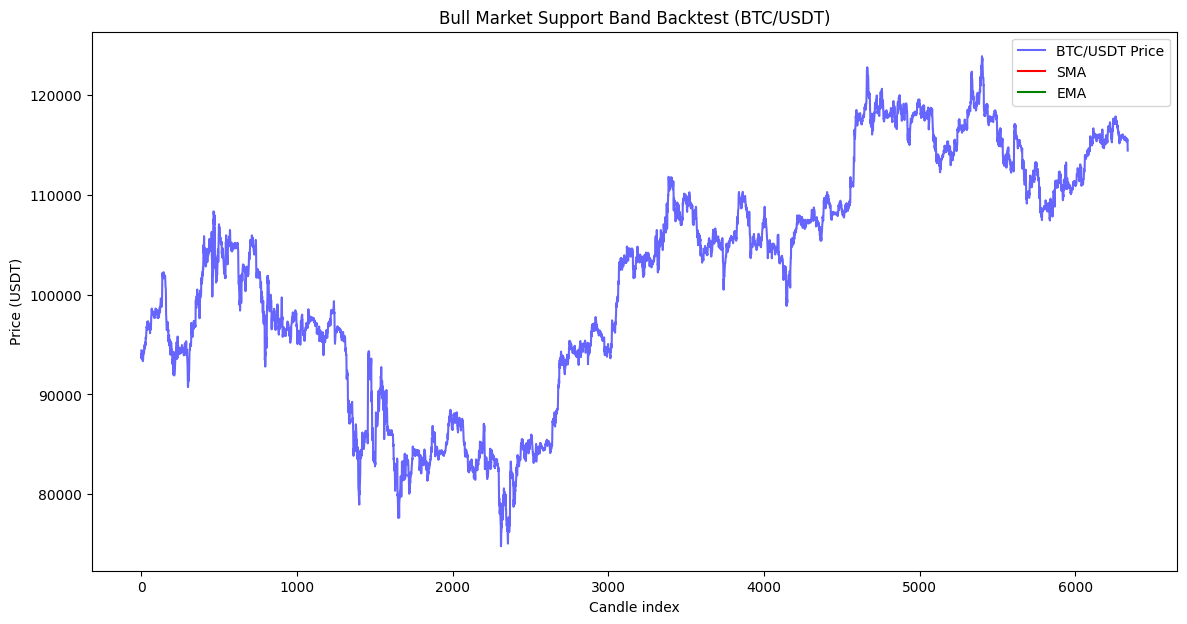

In [5]:
# bull_market_support_band_backtest.py
# Long-only SMA/EMA weekly strategy backtest with visualization
# Requires: pandas, numpy, matplotlib
# Install: pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Params ----------
CSV_PATH = "BTCUSDT_1h_6months2.csv"   # your OHLCV file
INITIAL_CAPITAL = 1000                # starting balance (USD)
SMA_LENGTH = 20                        # weekly SMA length
EMA_LENGTH = 21                        # weekly EMA length
START_DATE = "2025-01-01"
END_DATE = "2025-09-22"
# ----------------------------

# --- Load data ---
df = pd.read_csv(CSV_PATH)
df.columns = [c.lower() for c in df.columns]
for c in ['open','high','low','close','volume']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[(df['timestamp'] >= START_DATE) & (df['timestamp'] <= END_DATE)].reset_index(drop=True)

# --- Resample to weekly for SMA/EMA ---
weekly = df.resample('W', on='timestamp').agg({'close':'last'})
weekly['sma'] = weekly['close'].rolling(SMA_LENGTH).mean()
weekly['ema'] = weekly['close'].ewm(span=EMA_LENGTH, adjust=False).mean()

# Merge back weekly indicators to original dataframe
df = df.merge(weekly[['sma','ema']], left_on=df['timestamp'].dt.to_period('W').dt.start_time, right_on=weekly.index, how='left')
df.rename(columns={'key_0':'week_start'}, inplace=True)
df.fillna(method='ffill', inplace=True)  # forward-fill indicators

# --- Backtest logic ---
cash = INITIAL_CAPITAL
position = 0.0
trades = []

for i in range(len(df)):
    row = df.iloc[i]
    price = row['close']

    # Long condition: close > both SMA and EMA
    if position == 0 and price > row['sma'] and price > row['ema']:
        position = cash / price
        cash = 0
        trades.append({"index": i, "price": price, "side": "buy"})

    # Exit condition: price <= either SMA or EMA
    elif position > 0 and (price <= row['sma'] or price <= row['ema']):
        cash = position * price
        position = 0
        trades.append({"index": i, "price": price, "side": "sell"})

# Final balance
if position > 0:
    cash = position * df['close'].iloc[-1]
final_balance = cash

# --- Results ---
print("=== Bull Market Support Band Backtest ===")
print(f"Initial capital: ${INITIAL_CAPITAL:.2f}")
print(f"Final capital: ${final_balance:.2f}")
print(f"Net Profit: {final_balance - INITIAL_CAPITAL:.2f} USD")
print(f"Total trades executed: {len(trades)}")

# --- Visualization ---
plt.figure(figsize=(14,7))
plt.plot(df['close'], label="BTC/USDT Price", color="blue", alpha=0.6)
plt.plot(df['sma'], label="SMA", color="red")
plt.plot(df['ema'], label="EMA", color="green")

# mark trades
for t in trades:
    if t['side'] == "buy":
        plt.scatter(t['index'], t['price'], marker="^", color="green", s=100)
    elif t['side'] == "sell":
        plt.scatter(t['index'], t['price'], marker="v", color="red", s=100)

plt.title("Bull Market Support Band Backtest (BTC/USDT)")
plt.xlabel("Candle index")
plt.ylabel("Price (USDT)")
plt.legend()
plt.show()
